In [40]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

In [41]:
fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

### Confirm Existence of .netrc file in your home directory

In [42]:
# make a .netrc file in your home directory with the following
# machine urs.earthdata.nasa.gov login ifenty password XCfK5QhgEGuWVgu4qRuH
# for login and password use your EarthData login

# if this command returns 1, you are good

In [43]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [44]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)
#Need to have an .netrc file with updated password!

In [45]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2024-08-16 22:36:36+00:00.



# Define important params

In [46]:
# ECCO Starts on Jan 1, 1992
# ECCO_start_time= np.datetime64('1992-01-01')
ECCO_start_time= np.datetime64('1992-09-23')
alongtrack_file_dir = Path('/home/jpluser/ECCO_GMSL/Data')

# output directory
output_dir=Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied')
output_dir.mkdir(exist_ok=True)

# Load the ECCO spatial mean 1992-2017

In [47]:
ecco_mean = xr.open_dataset(str(alongtrack_file_dir) + '/ECCO_V4r4_mean_SSH_alllatnosicapplied.nc')
ecco_mean

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 360, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    mean_ssh   (latitude, longitude) float32 1MB ...

# Find the x,y points for each of the cycle days

## Load the AlongTrack x,y,t file

In [48]:
alongtrack = xr.open_dataset(str(alongtrack_file_dir) + '/AlongTrack_sample.nc', decode_times=False)
alongtrack

<xarray.Dataset> Size: 16MB
Dimensions:   (i: 602812)
Coordinates:
  * i         (i) int64 5MB 0 1 2 3 4 5 ... 602807 602808 602809 602810 602811
Data variables:
    time      (i) int64 5MB ...
    y         (i) float32 2MB ...
    x         (i) float32 2MB ...
    orbit_nb  (i) int16 1MB ...

## Create a dictionary with x,y points for each of the 10 cycle days

In [49]:
print(alongtrack.time.min())
print(alongtrack.time.max())
print(len(alongtrack.time))

<xarray.DataArray 'time' ()> Size: 8B
array(0)
<xarray.DataArray 'time' ()> Size: 8B
array(856657)
602812


In [50]:
np.min(alongtrack.y)

<xarray.DataArray 'y' ()> Size: 4B
array(-66.14912, dtype=float32)

In [51]:
x_track_in_d = {}
y_track_in_d = {}

alongtrack_swath = {}
tc = 0
all_ins = []
for d in range(10):
    d_start = d*86400
    d_end = d_start + 86400
    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]
    
    all_ins.append(ins) 
    x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])
    
    print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')
    
    tc = tc + len(ins)
    # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
    alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

cycle day: 0, time_start 0s, time_end 86400s, number of xy points 59523
cycle day: 1, time_start 86400s, time_end 172800s, number of xy points 60551
cycle day: 2, time_start 172800s, time_end 259200s, number of xy points 61022
cycle day: 3, time_start 259200s, time_end 345600s, number of xy points 60572
cycle day: 4, time_start 345600s, time_end 432000s, number of xy points 61407
cycle day: 5, time_start 432000s, time_end 518400s, number of xy points 60498
cycle day: 6, time_start 518400s, time_end 604800s, number of xy points 60235
cycle day: 7, time_start 604800s, time_end 691200s, number of xy points 60658
cycle day: 8, time_start 691200s, time_end 777600s, number of xy points 60949
cycle day: 9, time_start 777600s, time_end 864000s, number of xy points 57397


In [52]:
# sanity check the range of xy points 
for d in range(10):
    print(f'cycle day {d} min and max longitudes: \
        {np.nanmin(x_track_in_d[d].values), np.nanmax(x_track_in_d[d].values)}')

cycle day 0 min and max longitudes:         (-179.99864, 179.99623)
cycle day 1 min and max longitudes:         (-179.9978, 179.99731)
cycle day 2 min and max longitudes:         (-179.99812, 179.99065)
cycle day 3 min and max longitudes:         (-179.99268, 179.99953)
cycle day 4 min and max longitudes:         (-179.9971, 179.9989)
cycle day 5 min and max longitudes:         (-179.99747, 179.99992)
cycle day 6 min and max longitudes:         (-179.99892, 179.99971)
cycle day 7 min and max longitudes:         (-179.99136, 179.9993)
cycle day 8 min and max longitudes:         (-179.98524, 179.99416)
cycle day 9 min and max longitudes:         (-179.99942, 179.99695)


# Prepare ECCO Daily SSH dataset

In [53]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

In [54]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

## Make a "direct connection" to the S3 file system

In [55]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [56]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Make a list of all of the ECCO SSH dataset files for some arbitrary year

In [18]:
import time

In [19]:
year = 1993

start_time = time.time()

ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
print(f'time to find urls: { time.time() - start_time} s')

pprint(ECCO_SSH_files[0:5])
print('...')
pprint(ECCO_SSH_files[-5:])

time to find urls: 5.262634992599487 s
['podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-01-01_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-01-02_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-01-03_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-01-04_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-01-05_ECCO_V4r4b_latlon_0p50deg.nc']
...
['podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-12-27_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1993-12-28_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_S

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

Note: this takes a minute.

In [20]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:38643")
# client

In [21]:
year=1992
start_time = time.time()
ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
paths=[fs.open(f) for f in ECCO_SSH_files]

ECCO_DS_daily = xr.open_mfdataset(
paths=paths,
combine='nested',
concat_dim='time',
decode_cf=True,
coords='minimal',
chunks={'time': 1}  
)
ECCO_DS_daily.close()

ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)

# Loop through all days
for f in range(len(ECCO_SSH.time)):

    # get the date/time associated with this record
    rec_time = ECCO_SSH.time.dt.floor("D")[f]

    # Determine which cycle day we're in
    # ... count how many days since ecco start time?
    delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)
    if delta_days>=0:

        # Determine which GSFC cycle it is
        cycle = int(np.floor(delta_days / 10)+1)

        # ... cycle day is delta_days mod 10
        cycle_day = delta_days % 10

        # print(f'record day of year {str(rec_time.values)[0:10]}, cycle day {cycle_day}')

        # sample the ECCO field at the x,y locations for this cycle day 
        # search within a 200 km radius for the nearest neighbor.
        # (overkill since it's a 1 degree model but just to be safe)

        ECCO_at_xy_points =\
            kd_tree.resample_nearest(ECCO_grid_def, \
                                     ECCO_SSH[f].values, \
                                     alongtrack_swath[cycle_day],\
                                     radius_of_influence=200000, fill_value = np.nan)


In [57]:
for year in range(1992,2018):#1992,2018
    
    start_time = time.time()
    ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
    paths=[fs.open(f) for f in ECCO_SSH_files]
    
    ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
    ECCO_DS_daily.close()

    ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
    ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
    ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)
    
    # Loop through all days
    for f in range(len(ECCO_SSH.time)):

        # get the date/time associated with this record
        rec_time = ECCO_SSH.time.dt.floor("D")[f]

        # Determine which cycle day we're in
        # ... count how many days since ecco start time?
        delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)
        if delta_days>=0:

            # Determine which GSFC cycle it is
            cycle = int(np.floor(delta_days / 10)+1)

            # ... cycle day is delta_days mod 10
            cycle_day = delta_days % 10

            # print(f'record day of year {str(rec_time.values)[0:10]}, cycle day {cycle_day}')

            # sample the ECCO field at the x,y locations for this cycle day 
            # search within a 200 km radius for the nearest neighbor.
            # (overkill since it's a 1 degree model but just to be safe)

            ECCO_at_xy_points =\
                kd_tree.resample_nearest(ECCO_grid_def, \
                                         ECCO_SSH[f].values, \
                                         alongtrack_swath[cycle_day],\
                                         radius_of_influence=200000, fill_value = np.nan)

            # make a new DataArray object
            ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points, dims=['i'])
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
            ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
            ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
            ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

            ECCO_at_xy_points_da.name = 'SSH_at_xy'
            ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'

            # Save to Disk
            new_fname = 'ECCO_V4r4_alongtrack_SSH_' + str(rec_time.values).split('T')[0] + '.nc'
            ECCO_at_xy_points_da.to_netcdf(output_dir / new_fname)
    
    print(year, time.time() - start_time, cycle)

2003 114.84182119369507 412
2004 103.64416265487671 449
2005 119.22875618934631 485


In [23]:
ECCO_DS_daily

<xarray.Dataset> Size: 1GB
Dimensions:         (time: 365, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 3kB 2017-01-01T12:00:00 ... 2017-12...
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 378MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 378MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 378MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            2017-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          2017-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         e3e503f9-790e-48ec-bca3-e03c88d02191

In [24]:
ECCO_at_xy_points_da

<xarray.DataArray 'SSH_at_xy' (i: 59523)> Size: 238kB
array([       nan,        nan,        nan, ..., 0.07604074, 0.07604074,
       0.07604074], dtype=float32)
Coordinates:
    time        datetime64[ns] 8B 2017-12-31
    cycle_day   int64 8B 0
    cycle       int64 8B 924
    delta_days  int64 8B 9230
    lon         (i) float32 238kB 100.7 100.8 100.8 100.8 ... 53.27 53.34 53.41
    lat         (i) float32 238kB 2.303 2.353 2.402 ... -57.24 -57.2 -57.17
Dimensions without coordinates: i
Attributes:
    source:   ECCO V4r4

# Plot 10 days of along track SSH

In [25]:
year=1992
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))

In [26]:
tmp = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp.append(xr.open_dataset(ECCO_alongtrack_files[d]))
    print(ECCO_alongtrack_files[d])

/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-26.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-27.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-28.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-29.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-30.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-10-01.nc
/home/jpluser/ECCO_

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


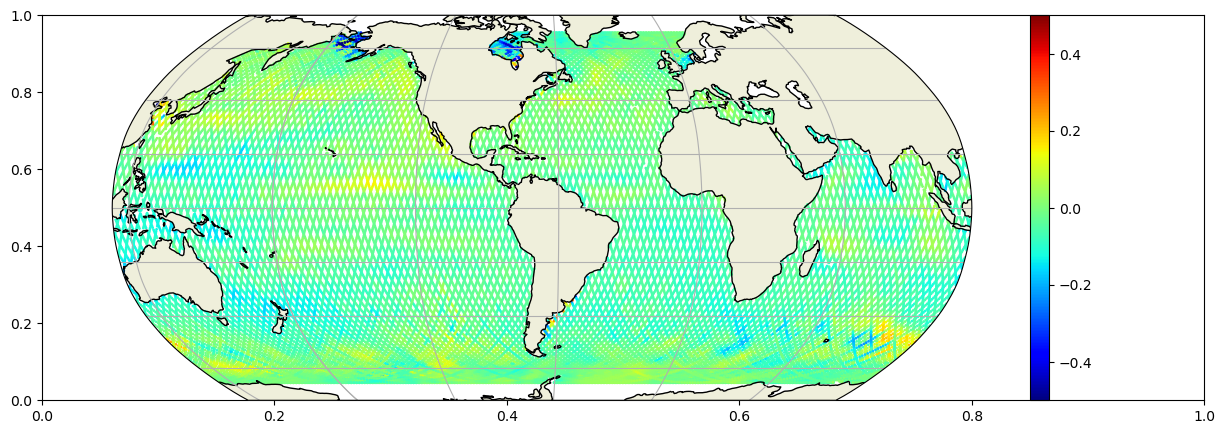

In [27]:
#Plot cycle 1 starting in 09/23/1992

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')
h=plt.colorbar(p)

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


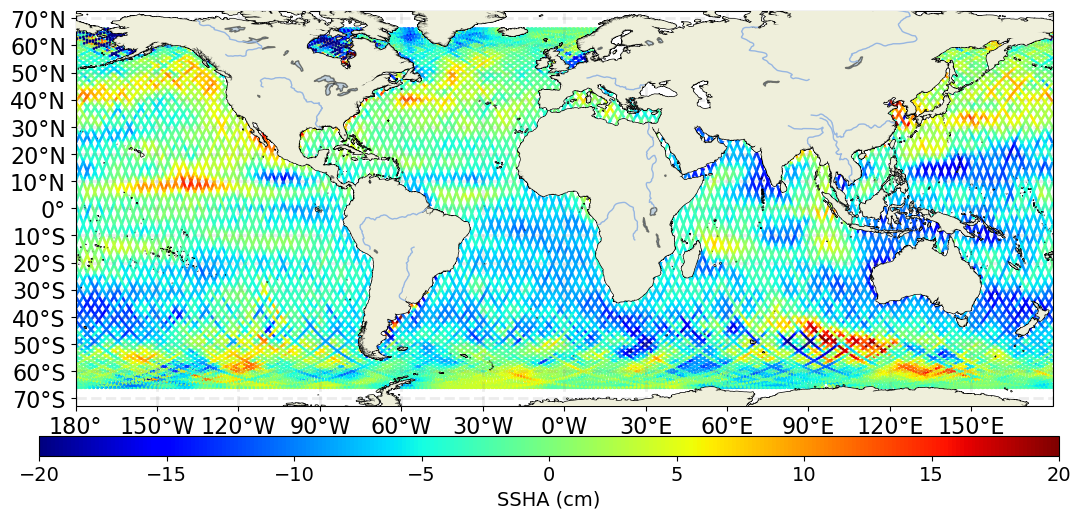

In [28]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')
    pp = plt.scatter(ECCO_at_xy.lon[::kk],ECCO_at_xy.lat[::kk],c=ECCO_at_xy[::kk]*100, s=1,cmap=palette,vmin=-20,vmax=20,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('SSHA (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_nosicapplied.png',dpi=200,transparent=False,facecolor='white')

In [29]:
tmp[2].SSH_at_xy

<xarray.DataArray 'SSH_at_xy' (i: 61022)> Size: 244kB
[61022 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B ...
    cycle_day   int64 8B 2
    cycle       int64 8B ...
    delta_days  int64 8B ...
    lon         (i) float32 244kB ...
    lat         (i) float32 244kB ...
Dimensions without coordinates: i
Attributes:
    source:   ECCO V4r4

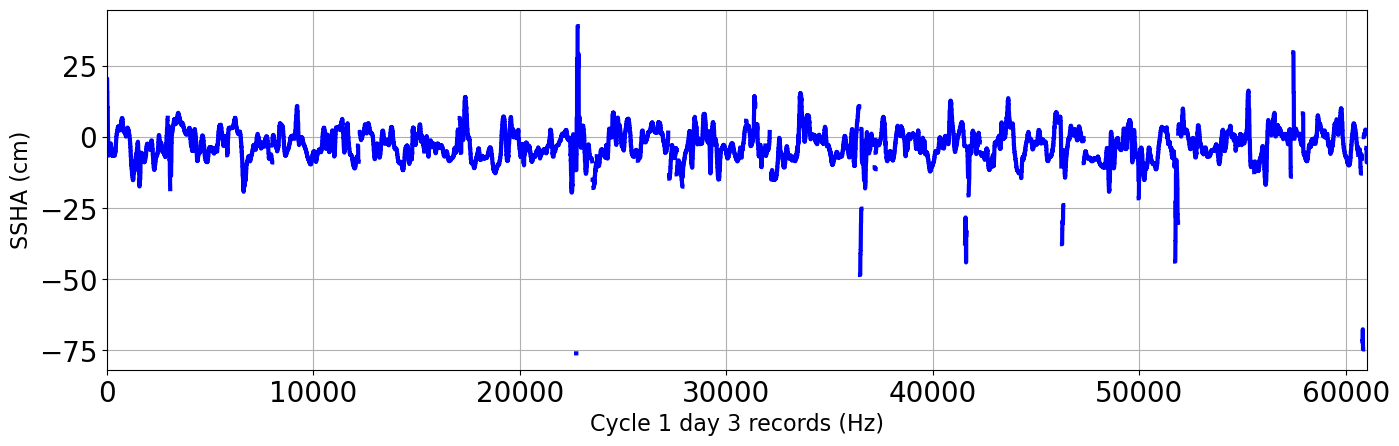

In [30]:
ECCO_at_xy = tmp[2].SSH_at_xy
# fig = plt.figure(figsize=(15,5))
# plt.plot(ECCO_at_xy)
# plt.ylim([-0.8,0.4])
# plt.xlim([0,65000])
# plt.title('ECCO SSH')

fig,ax=plt.subplots(figsize=(15,5))
(ECCO_at_xy*100).plot(color='b',linestyle='-',linewidth=3)
plt.grid()
# plt.ylim([-2,5])
plt.tick_params(axis='both', which='major', labelsize =20)
ax.set_ylabel('SSHA (cm)',fontsize=16)
ax.set_xlabel('Cycle 1 day 3 records (Hz)',fontsize=16)
ax.set_xlim([0, len(ECCO_at_xy)])
plt.title('')
ax.tick_params(axis='both', which='major', labelsize =20)
plt.subplots_adjust(left=0.13,top=0.93,bottom=0.21,right=0.97)
plt.savefig(fig_dir / 'ts_cycle1_nosicapplied.png',dpi=200,transparent=False,facecolor='white')


In [31]:
year=1993
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '-04*nc')))

In [32]:
tmp2 = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp2.append(xr.open_dataset(ECCO_alongtrack_files[d]))
    print(ECCO_alongtrack_files[d])

/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-01.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-02.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-03.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-04.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-05.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-06.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-07.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-08.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1993-04-09.nc
/home/jpluser/ECCO_

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


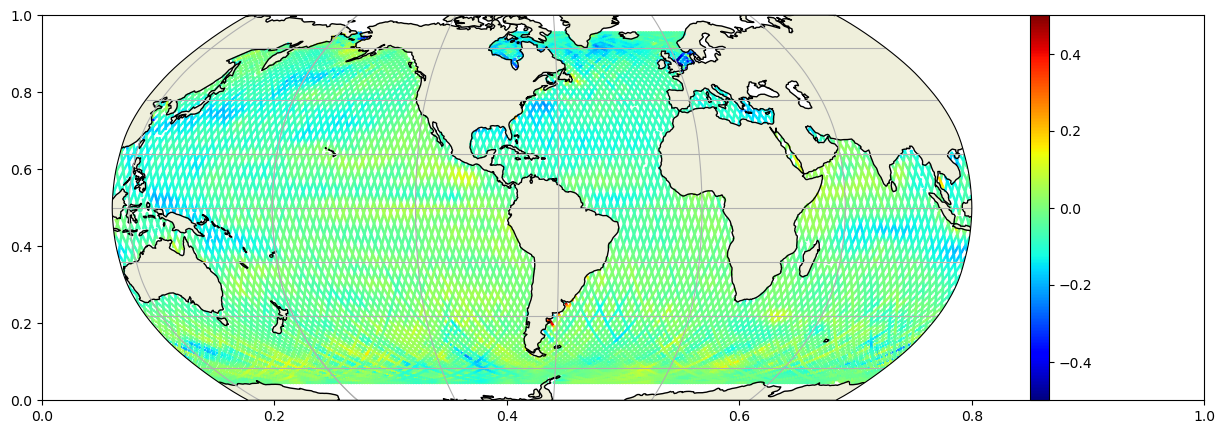

In [33]:
#Plot cycle starting in 01/01/1993

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp2[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')
h=plt.colorbar(p)


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


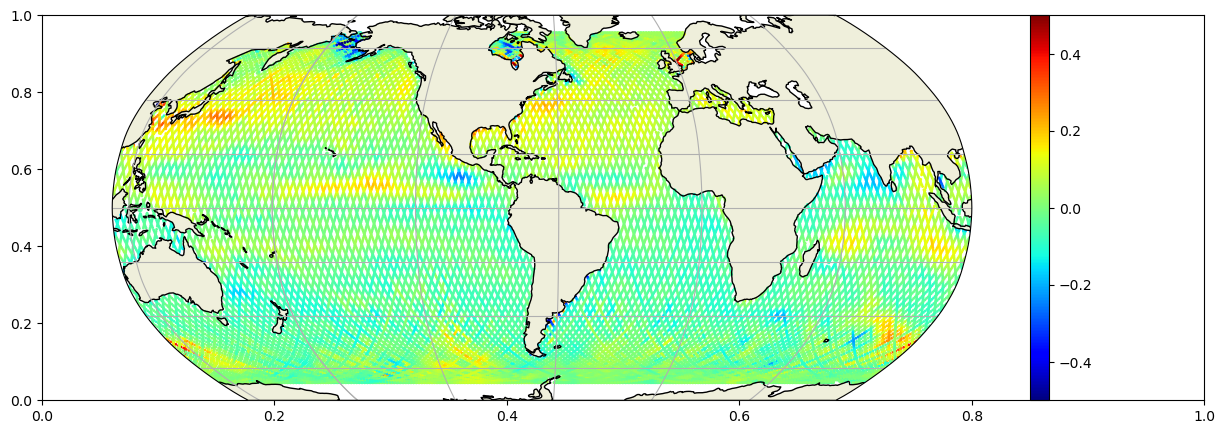

In [34]:
#Plot the difference between these 2 cycles

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy-tmp2[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')
h=plt.colorbar(p)

In [35]:
max = xr.concat(tmp, dim='i')
print(max.mean().values)
print(max.max().values)
print(max.min().values)

<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 1
Data variables:
    SSH_at_xy  float32 4B -0.0288>
<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 1
Data variables:
    SSH_at_xy  float32 4B 0.5148>
<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 1
Data variables:
    SSH_at_xy  float32 4B -0.789>


In [36]:
min = xr.concat(tmp2, dim='i')
print(min.mean().values)
print(min.max().values)
print(min.min().values)

<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 20
Data variables:
    SSH_at_xy  float32 4B -0.03587>
<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 20
Data variables:
    SSH_at_xy  float32 4B 0.5762>
<bound method Mapping.values of <xarray.Dataset> Size: 12B
Dimensions:    ()
Coordinates:
    cycle      int64 8B 20
Data variables:
    SSH_at_xy  float32 4B -0.6347>
